In [1]:
# Install packages
# pipenv --python 3.11.0 install scikit-learn scipy pandas matplotlib seaborn ipykernel pingouin fastapi pydantic streamlit uvicorn requests

In [2]:
# Libs para rodar o EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Carregar os dados
df = pd.read_csv('datasets/salarios.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [5]:
# Criar cópias do DF
df_eda = df.copy()
df_bucketing = df.copy()

In [6]:
# Vamos iniciar o EDA

# Visualizar os dados
df.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [7]:
# Verificar missing values
df.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [8]:
# Extrair as medidas estatísticas do dataset
df.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


- As features estão bem preenchidas, sem mostrar muitos erros, temos a média e mediana muito parecidas
- O mesmo não acontece com nossa variável dependente, pois a média e mediana são muito diferentes

<Axes: xlabel='tempo_na_empresa'>

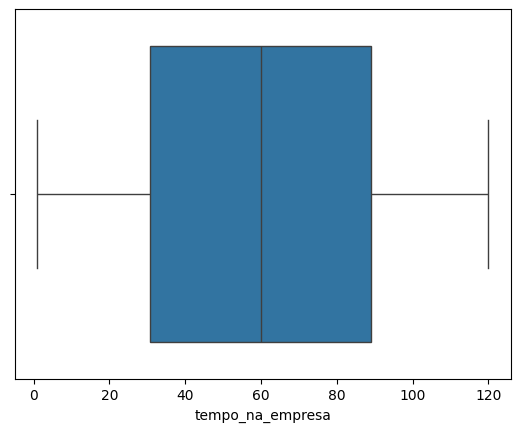

In [9]:
# Verificar outliers
sns.boxplot(data=df, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

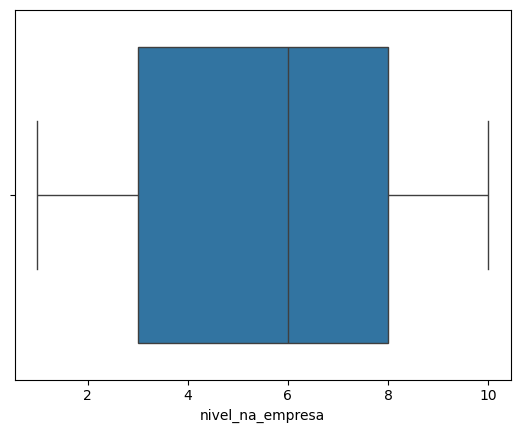

In [10]:
# Verificar outliers
sns.boxplot(data=df, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

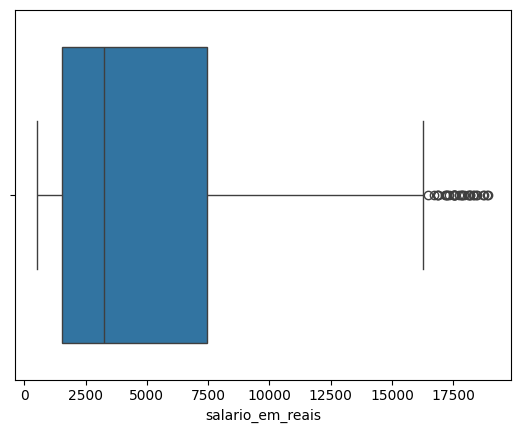

In [11]:
# Verificar outliers
sns.boxplot(data=df, x='salario_em_reais')

- Com a verificação de outliers, a gente confirma o que vimos nos dados estatísticos, o salário não tem uma distribuição normal

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

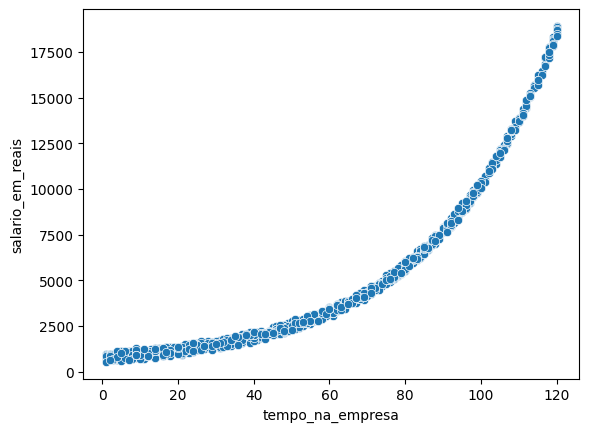

In [12]:
# Cruzamento das variáveis numéricas com a variável dependente, no caso o salário
sns.scatterplot(data=df_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

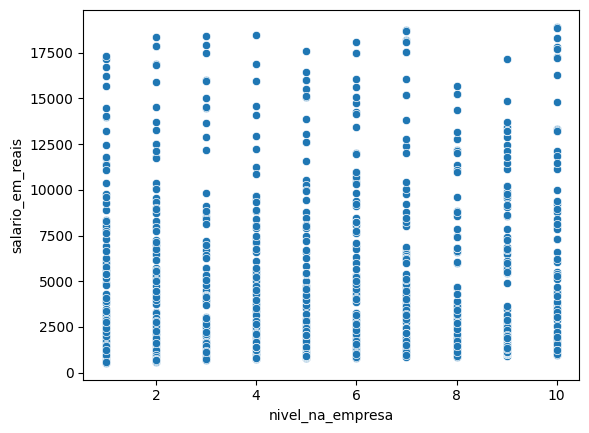

In [13]:
sns.scatterplot(data=df_eda, x='nivel_na_empresa', y='salario_em_reais')

- Com o tempo na empresa, não temos uma distribuição linear, mas sim uma distribuição logarítmica, vamos provar isso estatisticamente depois
- Com o nível na empresa, não parece ser relevante na predição do salário, com uma distribuição uniforme.

<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

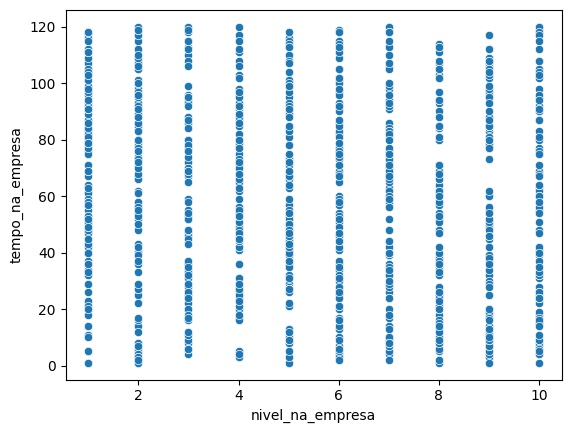

In [14]:
sns.scatterplot(data=df_eda, x='nivel_na_empresa', y='tempo_na_empresa')

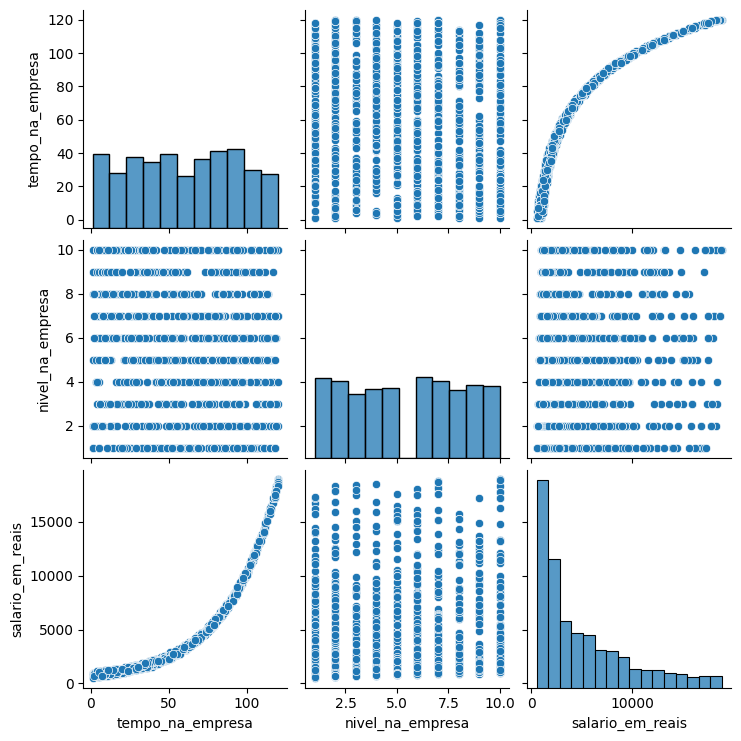

In [15]:
# Vamos fazer um histograma agora
sns.pairplot(df_eda)

- Conclusão, existe uma correlação não linear entre tempo de empresa e salário.

<Axes: >

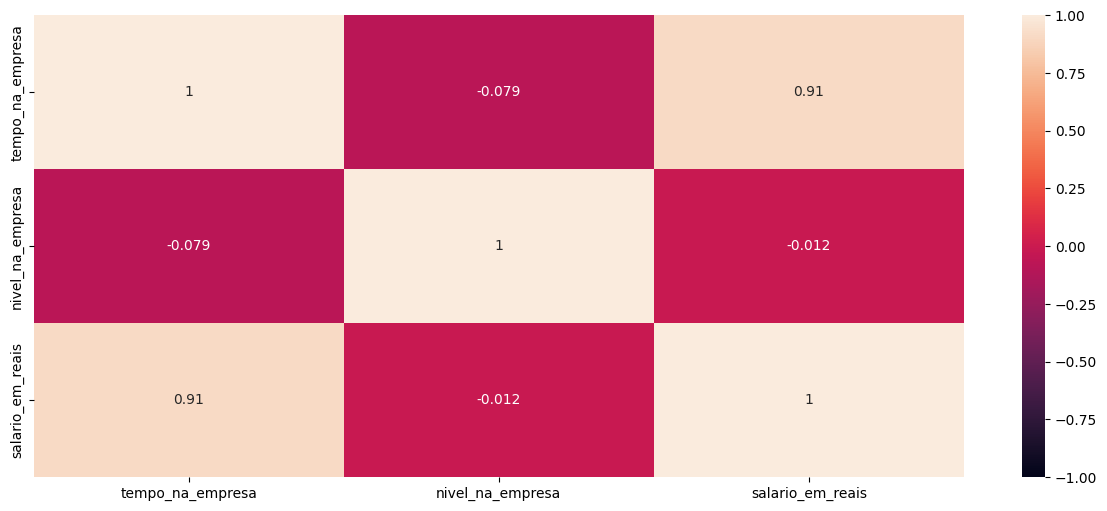

In [16]:
# Diagrama de correlação - Heatmap - Pearson
plt.figure(figsize=(15,6))
sns.heatmap(df_eda.corr('pearson'), annot=True, vmin=-1, vmax=1)

<Axes: >

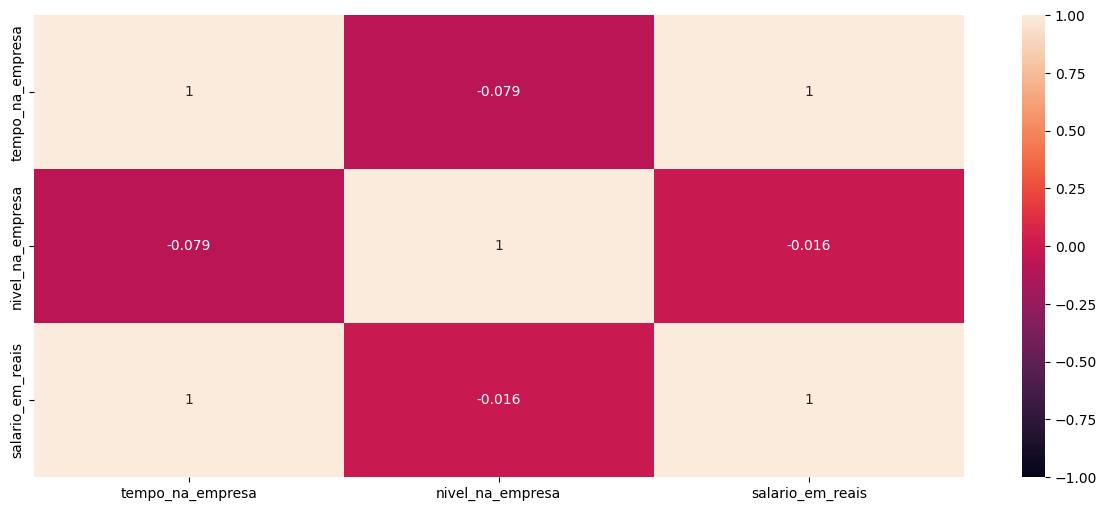

In [17]:
# Diagrama de correlação - Heatmap - Spearman
plt.figure(figsize=(15,6))
sns.heatmap(df_eda.corr('spearman'), annot=True, vmin=-1, vmax=1)

- A correlação de Pearson, chegamos em 0.91
- Usando Spearman, que é uma boa análise para correlações não lineares, chegamos em 1

<Axes: >

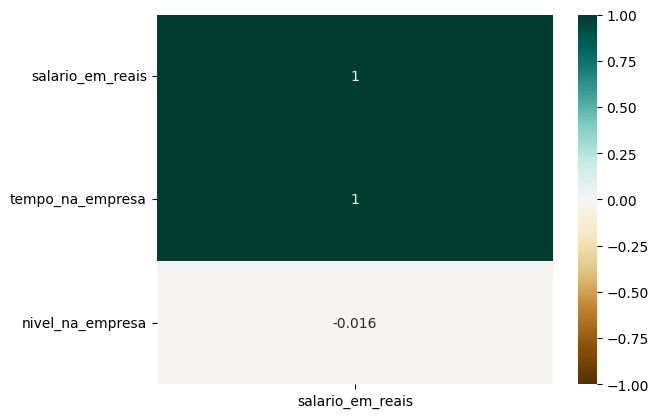

In [18]:
# Formato de Rankin
sns.heatmap(df_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), annot=True, cmap='BrBG', vmin=-1, vmax=1)

In [19]:
# Vamos fazer um bucketing com o Tempo de casa
bins_tempo_casa = [0,10,20,30,40,50,60,70,80,90,100,110,120,130]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129']

df_bucketing['escala_tempo'] = pd.cut(x=df_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)



In [20]:
df_bucketing.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

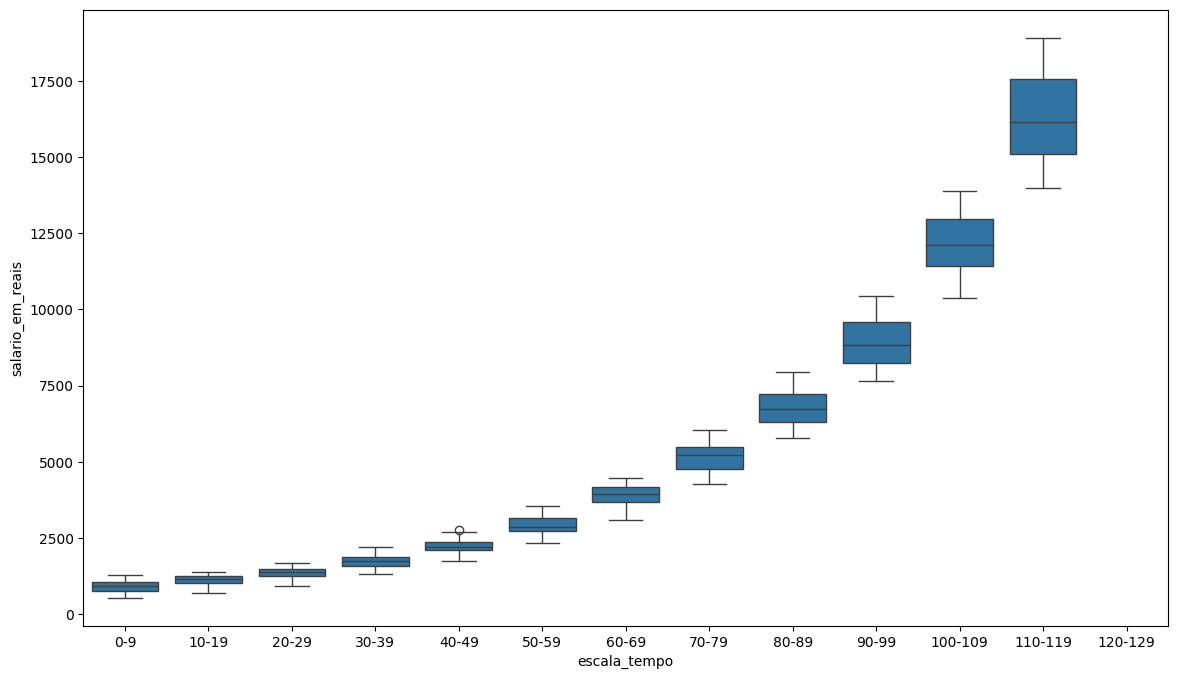

In [21]:
# Vamos grafar esta nova dimensão
plt.figure(figsize=(14,8))
sns.boxplot(df_bucketing, x="escala_tempo", y="salario_em_reais")

# Regressão linear

In [22]:
# Importar bibliotecas
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np


In [23]:
# Criar o dataset de treinamento e teste
X = df.drop(columns='salario_em_reais', axis=1)
y = df['salario_em_reais']

In [24]:
# Fazer o split dos dados
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [25]:
# Treinamento do modelo de regressão linear

# Pipeline
# Padronizar variáveis numéricas - tempo_na_empresa e nivel_na_empresa

# Nomes das colunas
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer das colunas
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar o ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

# Criar o pipeline principal - preprocessor e treinamento do modelo
model_regressao = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Armazenar RMSE Treino e Teste (validar se o modelo está dando overfit)
# Temos menos erros no treinamento do que no teste.
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar o R2 Score de Teste
r2_scores_fold_test = []

# Armazenar os resíduos
residuos = []

# Armazenar as predições
y_pred_total = []

# Agora vamos fazer as iterações do nosso KFold
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  # Treinar o modelo
  model_regressao.fit(X_train, y_train)

  # Predições nos conjuntos de treinamento e teste
  y_train_pred = model_regressao.predict(X_train)
  y_test_pred = model_regressao.predict(X_test)

  # Calcular as métricas
  rmse_train = root_mean_squared_error(y_train, y_train_pred)
  rmse_test = root_mean_squared_error(y_test, y_test_pred)
  r2_test = r2_score(y_test, y_test_pred)

  # Calcular os resíduos
  residuos_test = np.array(y_test - y_test_pred)

  # Armazenar os resultados
  rmse_scores_fold_train.append(rmse_train)
  rmse_scores_fold_test.append(rmse_test)
  r2_scores_fold_test.append(r2_test)
  residuos.append(residuos_test)
  y_pred_total.append(y_test_pred)

# Tirar a média das métricas armazenadas
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2_test_final = np.mean(r2_scores_fold_test)

# Qual a diferença percentual entre o RMSE de treinamento e teste
rmse_difference = (rmse_test_final - rmse_train_final) / rmse_train_final * 100

# Temos uma lista de listas de resíduos, e precisamos dar um reshape para ficar unidimensional
residuos_total = np.array(residuos).reshape(-1)

# O mesmo para as predições
y_pred_total = np.array(y_pred_total).reshape(-1)


In [26]:
# Fazer a análise das métricas do modelo de regressão linear

print(f'RMSE de treinamento: {rmse_train_final}')
print(f'RMSE de teste: {rmse_test_final}')
print(f'Diferença percentual RMSE Treinamento e Teste: {rmse_difference}%')
print(f'R2 score de teste: {r2_test_final}')

RMSE de treinamento: 1882.8318426651392
RMSE de teste: 1886.4504221336076
Diferença percentual RMSE Treinamento e Teste: 0.19218813844503052%
R2 score de teste: 0.8261178870584761


- Com uma diferença de apenas 4 reais, não parece ter um overfit.

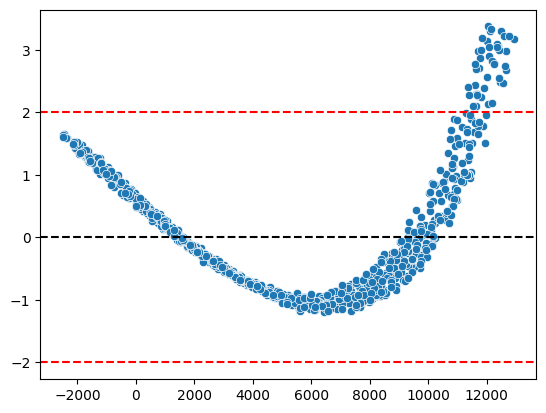

In [27]:
# Fazer a análise de resíduos do modelo de regressão linear

# Transformar os resíduos para a escala padrão
# (X - média) / desvio padrão

from scipy.stats import zscore

residuos_std = zscore(residuos_total)

# Verificar a linearidade dos resíduos (entre -2 e 2)
# Verificar a Homocedasticidade, se tem algum tendência ou formato

sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0, color='k', linestyle='--')
plt.axhline(y=-2, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')

- Os resíduos não seguem a reta: **Não há linearidade**
- Os resíduos não estão dispersos ao longo da reta, mas montam um shape be curva bem definido: **Não há homocedasticidade**

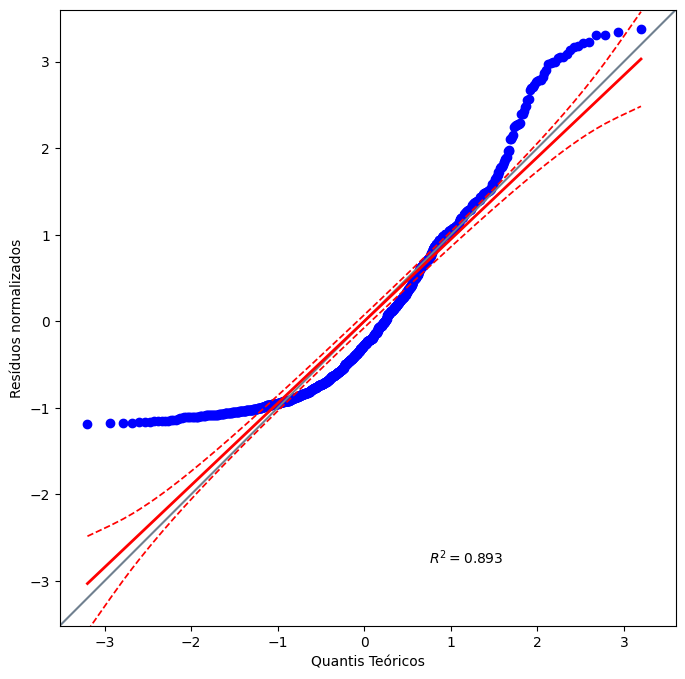

In [28]:
# Checar se resíduos seguem uma distribuição normal

import pingouin as pg

plt.figure(figsize=(14, 8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos normalizados')
plt.show()

- Fica claro que os valores não acompanham nem a reta nem nossa margem de segurança
- E temos um formato claro de uma curva

Nossa conclusão é que não segue um distribuição normal

In [29]:
# Vamos provar agora de forma estatística que não temos ums distribuições normal

from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

stat_shapiro, p_value_shapiro = shapiro(residuos_total)
print(f'Shapiro-Wilk test: {stat_shapiro} e p-value = {p_value_shapiro}')

Shapiro-Wilk test: 0.891969217965228 e p-value = 7.013497918013644e-26


- Muito abaixo de 0.05.

In [30]:
stat_kstest, p_value_kstest = kstest(residuos_total, 'norm')
print(f'Kolmogorov-Smirnov test: {stat_kstest} e p-value = {p_value_kstest}')

Kolmogorov-Smirnov test: 0.5939999999999955 e p-value = 0.0


- Novamente, abaixo de 0.05

In [31]:
stat_lilliefors, p_value_lilliefors = lilliefors(residuos_total, dist='norm', pvalmethod='table')
print(f'Lilliefors test: {stat_lilliefors} e p-value = {p_value_lilliefors}')

Lilliefors test: 0.11825983774680088 e p-value = 0.0009999999999998899


- Novamente abaixo de 0.05

Conclusão, todos os testes provam que os resíduos não seguem uma distribuição normal.

Vamos precisar treinar o modelo de forma diferente, fazendo um modelo polinomial.

In [32]:
# Nosso modelo não performou bem, temos mais de 1800 reais de margem de erro nas previsões
# Vamos tentar usar um modelo de regressão polinomial

# Exemplo de criação de features polinomiais
# Grau do polinômio é o maior grau da equação
# Temos 2 features em nosso caso, com um grau 3
# O bias é para ter sempre uma feature com valor fixo de 1, para não criar tendênciass no modelo
feat_poly = PolynomialFeatures(degree=3, include_bias=False)
X_test_poly = feat_poly.fit_transform(X)

# Verificar nossas features
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [33]:
# Verificar todas as features criadas
feat_poly.get_feature_names_out(feat_poly.feature_names_in_).size

9

- Foram mantidas as features originais
- Foram criadas outras 7 features com base em cálculos, por conta do grau 3, com o grau 2 por exemplo teríamos apenas mais 3 features novas

# Regressão polinomial


In [34]:
# Treinamento do modelo de regressão polinomial

# Como vamos descobrir o grau certo?
# Vamos testar 10 graus
graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

rmse_train_values = []
rmse_test_values = []
r2_values = []
rmse_difference_values = []

# Fazer o split dos dados
kf = KFold(n_splits=5, shuffle=True, random_state=51)

# Pipeline, iterando para cada grau
# Padronizar variáveis numéricas - tempo_na_empresa e nivel_na_empresa

for grau in graus_polynomial:

    # Nomes das colunas
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer das colunas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar o ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar as features polinomiais
    feat_poly = PolynomialFeatures(degree=grau, include_bias=False)

    # Criar o pipeline principal - preprocessor e treinamento do modelo
    model_polynomial = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', feat_poly),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE Treino e Teste (validar se o modelo está dando overfit)
    # Temos menos erros no treinamento do que no teste.
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar o R2 Score de Teste
    r2_scores_fold_test = []

    # Armazenar os resíduos
    residuos = []

    # Armazenar as predições
    y_pred_total = []

    # Agora vamos fazer as iterações do nosso KFold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Treinar o modelo
        model_polynomial.fit(X_train, y_train)

        # Predições nos conjuntos de treinamento e teste
        y_train_pred = model_polynomial.predict(X_train)
        y_test_pred = model_polynomial.predict(X_test)

        # Calcular as métricas
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Calcular os resíduos
        residuos_test = np.array(y_test - y_test_pred)

        # Armazenar os resultados
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2_scores_fold_test.append(r2_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    # Tirar a média das métricas armazenadas
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_test_final = np.mean(r2_scores_fold_test)

    # Qual a diferença percentual entre o RMSE de treinamento e teste
    rmse_difference = (rmse_test_final - rmse_train_final) / rmse_train_final * 100

    # Temos uma lista de listas de resíduos, e precisamos dar um reshape para ficar unidimensional
    residuos_total = np.array(residuos).reshape(-1)

    # O mesmo para as predições
    y_pred_total = np.array(y_pred_total).reshape(-1)

    # Armazenar os resultados computados de cada grau
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2_values.append(r2_test_final)
    rmse_difference_values.append(rmse_difference)

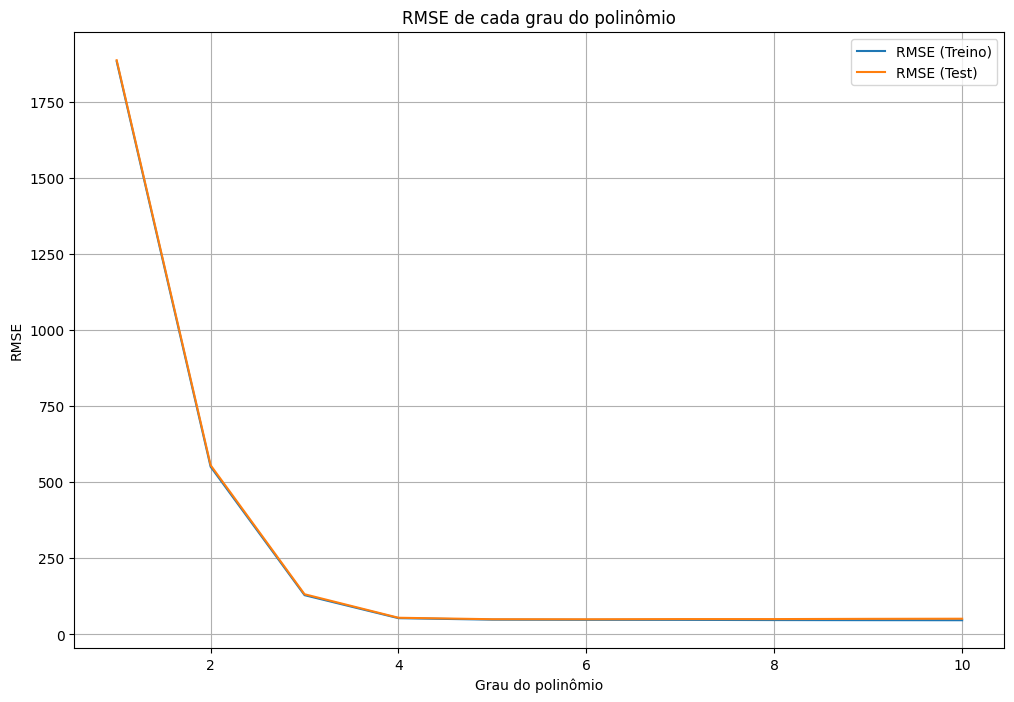

In [35]:
# Vamos agora indicar qual o grau com melhor performance
# Criar um gráfico para comparar o RMSE de cada grau

plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE (Test)')
plt.xlabel('Grau do polinômio')
plt.ylabel('RMSE')
plt.title('RMSE de cada grau do polinômio')
plt.legend()
plt.grid(True)
plt.show()

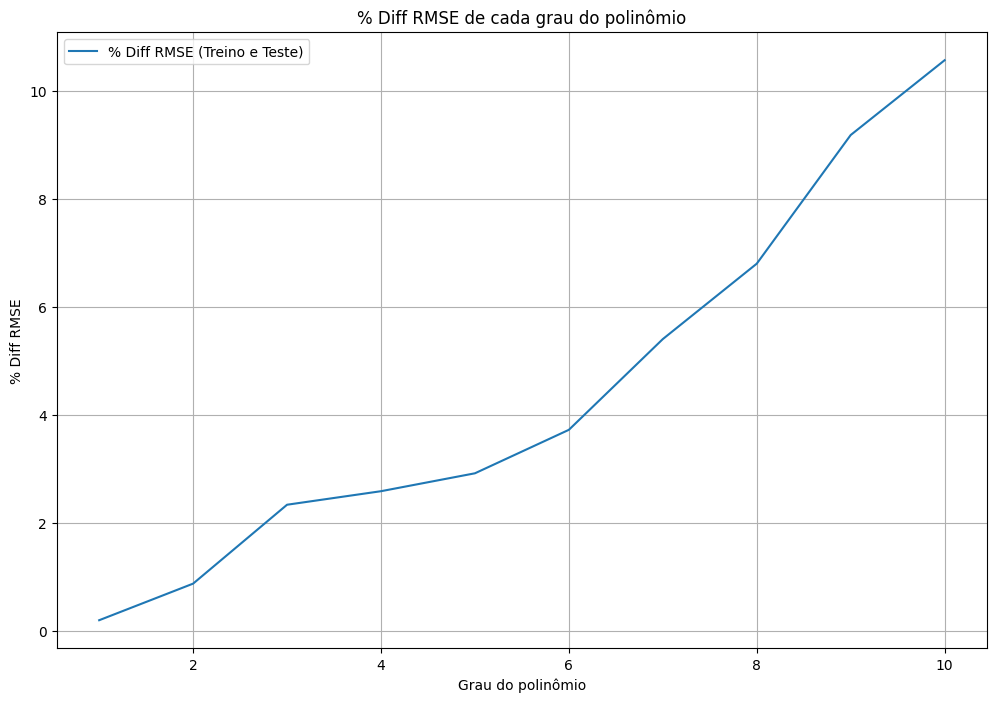

In [36]:
# Criar um gráfico para comparar a diferença do RMSE de cada grau

plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_difference_values, label='% Diff RMSE (Treino e Teste)')
plt.xlabel('Grau do polinômio')
plt.ylabel('% Diff RMSE')
plt.title('% Diff RMSE de cada grau do polinômio')
plt.legend()
plt.grid(True)
plt.show()

- A partir do grau 4 temos uma subida vertiginosa da diferença do RMSE
- O que confirma mais ainda usar o grau 4, para não cair em um overfit.

In [37]:
# Treinamento do modelo de regressão polinomial

# Vamos rodar agora só para o grau escolhido
graus_polynomial = [4]

rmse_train_values = []
rmse_test_values = []
r2_values = []
rmse_difference_values = []

# Fazer o split dos dados
kf = KFold(n_splits=5, shuffle=True, random_state=51)

# Pipeline, iterando para cada grau
# Padronizar variáveis numéricas - tempo_na_empresa e nivel_na_empresa

for grau in graus_polynomial:

    # Nomes das colunas
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer das colunas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar o ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar as features polinomiais
    feat_poly = PolynomialFeatures(degree=grau, include_bias=False)

    # Criar o pipeline principal - preprocessor e treinamento do modelo
    model_polynomial = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', feat_poly),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE Treino e Teste (validar se o modelo está dando overfit)
    # Temos menos erros no treinamento do que no teste.
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar o R2 Score de Teste
    r2_scores_fold_test = []

    # Armazenar os resíduos
    residuos = []

    # Armazenar as predições
    y_pred_total = []

    # Agora vamos fazer as iterações do nosso KFold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Treinar o modelo
        model_polynomial.fit(X_train, y_train)

        # Predições nos conjuntos de treinamento e teste
        y_train_pred = model_polynomial.predict(X_train)
        y_test_pred = model_polynomial.predict(X_test)

        # Calcular as métricas
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Calcular os resíduos
        residuos_test = np.array(y_test - y_test_pred)

        # Armazenar os resultados
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2_scores_fold_test.append(r2_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    # Tirar a média das métricas armazenadas
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_test_final = np.mean(r2_scores_fold_test)

    # Qual a diferença percentual entre o RMSE de treinamento e teste
    rmse_difference = (rmse_test_final - rmse_train_final) / rmse_train_final * 100

    # Temos uma lista de listas de resíduos, e precisamos dar um reshape para ficar unidimensional
    residuos_total = np.array(residuos).reshape(-1)

    # O mesmo para as predições
    y_pred_total = np.array(y_pred_total).reshape(-1)

    # Armazenar os resultados computados de cada grau
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2_values.append(r2_test_final)
    rmse_difference_values.append(rmse_difference)

In [38]:
# Fazer a análise das métricas do modelo de regressão polinomial

print(f'RMSE de treinamento: {rmse_train_final}')
print(f'RMSE de teste: {rmse_test_final}')
print(f'Diferença percentual RMSE Treinamento e Teste: {rmse_difference}%')
print(f'R2 score de teste: {r2_test_final}')

RMSE de treinamento: 53.32698559565158
RMSE de teste: 54.705043527963426
Diferença percentual RMSE Treinamento e Teste: 2.584166190755432%
R2 score de teste: 0.9998524123039415


- Caímos de 1800 reais para 53 reais
- Nosso R2 score subiu para quase 1.

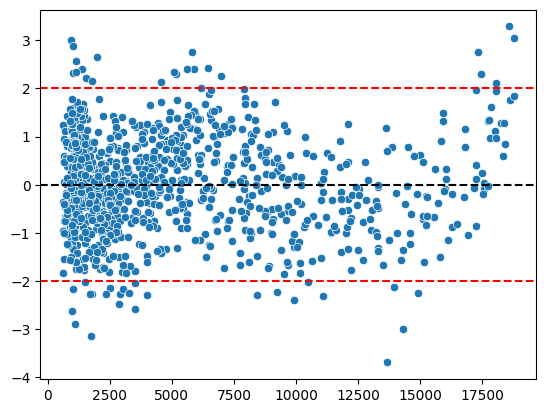

In [39]:
# Fazer a análise de resíduos do modelo de regressão linear

# Transformar os resíduos para a escala padrão
# (X - média) / desvio padrão

from scipy.stats import zscore

residuos_std = zscore(residuos_total)

# Verificar a linearidade dos resíduos (entre -2 e 2)
# Verificar a Homocedasticidade, se tem algum tendência ou formato

sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0, color='k', linestyle='--')
plt.axhline(y=-2, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')

- Nosso modelo melhorou muito em relação ao modelo de regressão linear, pois temos uma homocedasticidade bem maior.
- Temos também uma distribuição mais espalhada ao longo da reta, sem um shape definido.

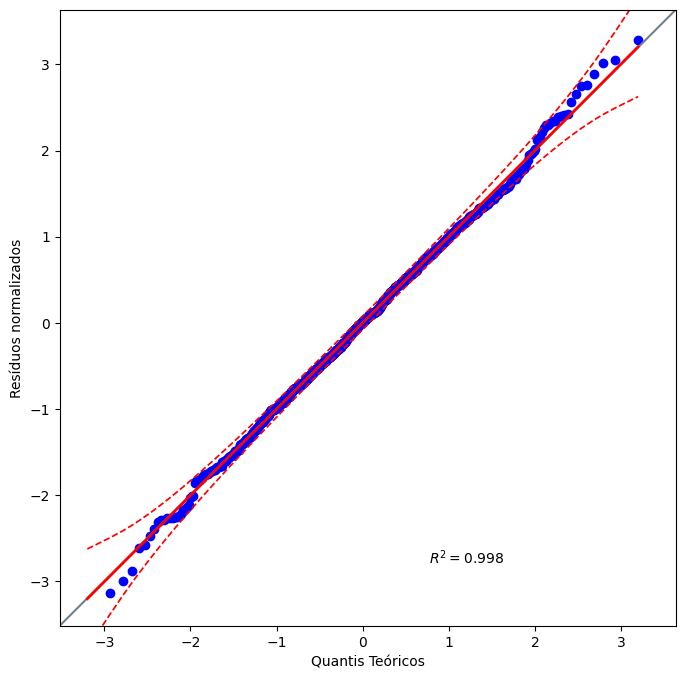

In [40]:
# Checar se resíduos seguem uma distribuição normal

import pingouin as pg

plt.figure(figsize=(14, 8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos normalizados')
plt.show()

- Aqui fica bem claro que os valores estão muito mais ajustados em relação à reta e dentro da banda de segurança.
- Os resíduos parecem seguir uma distribuição normal

In [41]:
# Vamos provar agora de forma estatística que não temos ums distribuições normal

from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

stat_shapiro, p_value_shapiro = shapiro(residuos_total)
print(f'Shapiro-Wilk test: {stat_shapiro} e p-value = {p_value_shapiro}')

Shapiro-Wilk test: 0.9986951372205314 e p-value = 0.6852797159654203


In [42]:
stat_kstest, p_value_kstest = kstest(residuos_total, 'norm')
print(f'Kolmogorov-Smirnov test: {stat_kstest} e p-value = {p_value_kstest}')

Kolmogorov-Smirnov test: 0.4823744649952717 e p-value = 1.220246010750369e-214


In [43]:
stat_lilliefors, p_value_lilliefors = lilliefors(residuos_total, dist='norm', pvalmethod='table')
print(f'Lilliefors test: {stat_lilliefors} e p-value = {p_value_lilliefors}')

Lilliefors test: 0.01363734689497198 e p-value = 0.9566270022047744


- Tivemos 2 de 3 testes indicando que os resíduos seguem uma distribuição normal.
- Podemos concluir que com certeza no modelo polinomial tivemos um ajuste muito melhor do que na regressão linear.

## Fazendo predições

In [49]:
# Vamos executar uma predição individual

input_features = {
  'tempo_na_empresa': 80,
  'nivel_na_empresa': 5
}

pred_df = pd.DataFrame(input_features, index=[1])

In [50]:
# Executar a predição

model_polynomial.predict(pred_df)

array([5747.79896506])

- As predições estão confirmando que o tempo de empresa tem mais impacto que o nível de empresa.

In [51]:
# Salvar o modelo
import joblib

joblib.dump(model_polynomial, './models/modelo_salario.pkl')


['./models/modelo_salario.pkl']